01_task_NW_load_data.ipynb

02_task_NW_strategies.ipynb

03_task_NW_EDA.ipynb

04_task_NW_backtest.ipynb <<<<< we're here

------

"Fair" backtest

------

However, the basic coefficients were "peeked at" during earlier steps.
So, this cannot be considered a truly clean backtest

# init

In [1]:
import numpy as np
import pickle
from typing import Optional, Dict, Any
import time

In [22]:
#for analize
import matplotlib.pyplot as plt
import pandas as pd

# load

In [2]:
with open('/content/drive/MyDrive/Colab Notebooks/data/test01/snapshots_D.pkl', 'rb') as file:
    snapshots_D = pickle.load(file)

with open('/content/drive/MyDrive/Colab Notebooks/data/test01/snapshots_receive_ms_D.pkl', 'rb') as file:
    snapshots_receive_ms_D = pickle.load(file)

with open('/content/drive/MyDrive/Colab Notebooks/data/test01/snapshots_server_ms_D.pkl', 'rb') as file:
    snapshots_server_ms_D = pickle.load(file)

with open('/content/drive/MyDrive/Colab Notebooks/data/test01/trades_D.pkl', 'rb') as file:
    trades_D = pickle.load(file)

with open('/content/drive/MyDrive/Colab Notebooks/data/test01/trades_receive_ms_D.pkl', 'rb') as file:
    trades_receive_ms_D = pickle.load(file)

with open('/content/drive/MyDrive/Colab Notebooks/data/test01/trades_server_ms_D.pkl', 'rb') as file:
    trades_server_ms_D = pickle.load(file)

with open('/content/drive/MyDrive/Colab Notebooks/data/test01/snapshots_B.pkl', 'rb') as file:
    snapshots_B = pickle.load(file)

with open('/content/drive/MyDrive/Colab Notebooks/data/test01/snapshots_receive_ms_B.pkl', 'rb') as file:
    snapshots_receive_ms_B = pickle.load(file)

with open('/content/drive/MyDrive/Colab Notebooks/data/test01/snapshots_server_ms_B.pkl', 'rb') as file:
    snapshots_server_ms_B = pickle.load(file)

with open('/content/drive/MyDrive/Colab Notebooks/data/test01/trades_B.pkl', 'rb') as file:
    trades_B = pickle.load(file)

with open('/content/drive/MyDrive/Colab Notebooks/data/test01/trades_receive_ms_B.pkl', 'rb') as file:
    trades_receive_ms_B = pickle.load(file)

with open('/content/drive/MyDrive/Colab Notebooks/data/test01/trades_server_ms_B.pkl', 'rb') as file:
    trades_server_ms_B = pickle.load(file)

# funcs

In [81]:
def vwap_price(side: int, snap: np.array, amount: float) -> float:
    if side == 1:
        side_idx = 0 #buy - by asks
    elif side == -1:
        side_idx = 1  # sell — by bids

    prices = snap[side_idx][0]
    volumes = snap[side_idx][1]

    remaining = amount
    total_cost = 0.0

    for p, v in zip(prices, volumes):
        if remaining <= 0:
            break
        tradable = min(v, remaining)
        total_cost += p * tradable
        remaining -= tradable

    filled = amount - remaining

    return total_cost / filled

In [163]:
def can_trade(pos_D: float, pos_B: float, side_D: int, side_B: int, amount: float, max_size: float) -> bool:
    new_pos_D = pos_D + side_D * amount
    new_pos_B = pos_B + side_B * amount
    return new_pos_D <= max_size and new_pos_B <= max_size

# timeserie

In [4]:
rms_list = np.union1d(snapshots_receive_ms_D, snapshots_receive_ms_B)

In [5]:
snapshots_idx_D = np.searchsorted(rms_list, snapshots_receive_ms_D)
snapshots_idx_B = np.searchsorted(rms_list, snapshots_receive_ms_B)

# classes

## position tracker

In [6]:
class PositionTracker:
    def __init__(self, fee: float):
        self.fee = fee
        self.position = 0.0
        self.pnl = 0.0
        self.contracts = 0.0
        self.avg_price = 0.0

    def calc_R(self, side: int, amount: float, price: float) -> float:
        return amount / price * (side - self.fee)

    def process_trade(self, side: int, amount: float, price: float) -> float:
        r = self.calc_R(side, amount, price)
        self.pnl += r
        self.position += side * amount

        qty = amount / price
        signed_qty = side * qty
        curr = self.contracts

        if curr * signed_qty > 0:
            new = curr + signed_qty
            self.avg_price = (
                self.avg_price * abs(curr)
                + price * abs(qty)
            ) / abs(new)
            self.contracts = new

        else:
            if abs(signed_qty) <= abs(curr):
                self.contracts = curr + signed_qty
                if abs(self.contracts) < 1e-12:
                    self.avg_price = 0.0
            else:
                flip = abs(signed_qty) - abs(curr)
                self.contracts = curr + signed_qty
                self.avg_price = price

        return r

    def get_position(self) -> float:
        return self.position

    def get_pnl(self) -> float:
        return self.pnl

    def get_position_usd(self, price: float) -> float:
        return self.contracts * price

    def get_avg_price(self) -> float:
        return self.avg_price


tracker = PositionTracker(fee=0.000)
r1 = tracker.process_trade(side=-1, amount=100_000, price=23_800)
print(tracker.get_position(), tracker.contracts, tracker.get_avg_price(), tracker.get_pnl())
r2 = tracker.process_trade(side=-1, amount=0_000, price=23_500)
print(tracker.get_position(), tracker.contracts, tracker.get_avg_price())
r3 = tracker.process_trade(side=+1, amount=0_000, price=23_000)
print(tracker.get_position(), tracker.contracts, tracker.get_avg_price())
r4 = tracker.process_trade(side=+1, amount=100_000, price=22_800)
print(tracker.get_position(), tracker.contracts, tracker.get_avg_price())

-100000.0 -4.201680672268908 23800 -4.201680672268908
-100000.0 -4.201680672268908 23800
-100000.0 -4.201680672268908 23800
0.0 0.18428424001179433 22800


## marketstate

In [20]:
class MarketState:
    def __init__(self):
        self.state = {
            'D': None,
            'B': None
        }
        self._mid  = {'D': None, 'B': None, 'S': None}
        self._time = {'D': None, 'B': None, 'S': None}

        self._best_prices = {'D': {'ask': None, 'bid': None}, 'B': {'ask': None, 'bid': None}}
        self._spreads = {'D':None, 'B':None}

        self._spreadDB = None
        self._spreadDBtime = None

        self._volumes_1 = {'D':[None, None], 'B':[None,None]}
        self._densities_10 = {'D':[None, None], 'B':[None,None]}
        self._imb_volume_1 = {'D':None,'B':None}
        self._imb_density_10 = {'D':None,'B':None}

    def get_variables(self):
        return {
            'spread_pct':self._spreadDB,
            'D_imb_volume_1':self._imb_volume_1['D'],
            'B_imb_volume_1':self._imb_volume_1['B'],
            'D_imb_density_10':self._imb_density_10['D'],
            'B_imb_density_10':self._imb_density_10['B'],
            'D_spread':self._spreads['D'],
            'B_spread':self._spreads['B']
        }

    def get_state(self):
        return self.state

    def get_orderbook(self, source: str) -> np.array:
        return self.state[source]

    def update(self,
               D_snap: Optional[np.array] = None,
               D_time: np.int64 = None,
               B_snap: Optional[np.array] = None,
               B_time: np.int64 = None) -> None:

        if D_snap is not None:
            self._process_snap('D', D_snap, D_time)
        if B_snap is not None:
            self._process_snap('B', B_snap, B_time)

        self._update_spread()

    def _update_spread(self):
        midD = self._mid['D']
        midB = self._mid['B']
        if midD is not None and midB is not None:
            self._spreadDB = (midD - midB)/midB*100
            self._spreadDBtime = np.max([self._time['D'], self._time['B']])

            for exch in ['D','B']:
                self._imb_volume_1[exch] = ( self._volumes_1[exch][0] - self._volumes_1[exch][1] ) / ( self._volumes_1[exch][0] + self._volumes_1[exch][1] )
                self._imb_density_10[exch] = ( self._densities_10[exch][0] - self._densities_10[exch][1] ) / ( self._densities_10[exch][0] + self._densities_10[exch][1] )

    def _process_snap(self, source: str, snap: np.array, time: np.int64) -> None:
        best_ask = snap[0, 0, 0]
        best_bid = snap[1, 0, 0]
        best_ask_volume = snap[0, 1, 0]
        best_bid_volume = snap[1, 1, 0]
        mid = (best_ask + best_bid) / 2

        self._mid[source] = mid
        self._time[source] = time
        self.state[source] = snap

        self._spreads[source] = (best_ask - best_bid)/best_bid*100

        self._volumes_1[source][0] = best_ask_volume
        self._volumes_1[source][1] = best_bid_volume

        self._densities_10[source][0] = (snap[0, 0, 9] - best_ask)/10
        self._densities_10[source][1] = (best_bid - snap[1, 0, 9])/10

        self._best_prices[source]['ask'] = best_ask
        self._best_prices[source]['bid'] = best_bid

    def get_midprice(self, source: str) -> Optional[float]:
        return self._mid.get(source)

    def get_midprice_delta(self, sourceA: str, sourceB: str) -> Optional[float]:
        midA = self._mid.get(sourceA)
        midB = self._mid.get(sourceB)
        return midA - midB

    def get_spread(self):
        return self._spreadDB, self._spreadDBtime

    def get_exch_spread(self, source: str) -> float:
        return self._spreads[source]

    def get_volumes_1(self, source: str):
        return self._volumes_1[source]

    def get_imb_density_10(self, source: str) -> float:
        return self._imb_density_10[source]

    def get_spot_agression(self):
        return self._spot_agression

    def get_best_prices(self):
        return self._best_prices

## ewm irregular

In [12]:
class OnlineIrregularEWMAdjust:
    def __init__(self, span: float, dt0: float = None):
        alpha0 = 2.0 / (span + 1.0)
        self._tau = None
        self._alpha0 = alpha0
        self._dt0 = dt0

        self._sum_weighted = None
        self._sum_weights  = None

        self._last_t     = None
        self._last_ewm   = None
        self._initialized = False

    def update(self, x_new: float, t_new: float) -> float:
        if np.isnan(x_new) or np.isnan(t_new):
            return self._last_ewm

        if not self._initialized:
            self._last_t       = t_new
            self._sum_weighted = x_new
            self._sum_weights  = 1.0
            self._last_ewm     = x_new
            self._initialized  = True
            return x_new

        dt = t_new - self._last_t
        if self._tau is None:
            dt0 = self._dt0 if self._dt0 is not None else dt
            self._tau = -dt0 / np.log(1 - self._alpha0)

        beta = np.exp(-dt / self._tau)

        self._sum_weighted = x_new + beta * self._sum_weighted
        self._sum_weights  = 1.0  + beta * self._sum_weights

        s_new = self._sum_weighted / self._sum_weights

        self._last_t     = t_new
        self._last_ewm   = s_new
        return s_new

# decide engines

## simple

In [247]:
def DE_simple(r, pos_size_D, pos_size_B, fee_Dx, fee_Bx, open_th, close_th, amount):

    #reduction position
    if pos_size_B > 0 and r['spread_pct_ewm_delta'] < -close_th * (fee_Bx + fee_Dx) * 100 and r['D_spread'] < 0.005 and r['B_spread'] < 0.005:
        is_action = True
        D_side = 1
        B_side = -1
        size = amount

    elif pos_size_D > 0 and r['spread_pct_ewm_delta'] > close_th * (fee_Bx + fee_Dx) * 100 and r['D_spread'] < 0.005 and r['B_spread'] < 0.005:
        is_action = True
        D_side = -1
        B_side = 1
        size = amount

    #incrise position
    elif r['spread_pct_ewm_delta'] > open_th * (fee_Bx + fee_Dx) * 100 and r['D_spread'] < 0.005 and r['B_spread'] < 0.005:
        is_action = True
        D_side = -1
        B_side = 1
        size = amount

    elif r['spread_pct_ewm_delta'] < -open_th * (fee_Bx + fee_Dx) * 100 and r['D_spread'] < 0.005 and r['B_spread'] < 0.005:
        is_action = True
        D_side = 1
        B_side = -1
        size = amount

    else:
        is_action = False
        D_side = 0
        B_side = 0
        size = 0

    return is_action, D_side, B_side, size

## linear regression

In [146]:
def y_b2d(delta, D_imb_volume_1, B_imb_volume_1, D_imb_density_10, B_imb_density_10, D_spread, B_spread):
    return 220.620697*delta + 0.140114*D_imb_volume_1 - 0.001411*B_imb_volume_1 - 0.314249*D_imb_density_10 + 1.263858*B_imb_density_10 - 170.401439*D_spread - 210.285162*B_spread

def y_d2b(delta, D_imb_volume_1, B_imb_volume_1, D_imb_density_10, B_imb_density_10, D_spread, B_spread):
    return -232.343499*delta + 0.010519*D_imb_volume_1 - 0.009755*B_imb_volume_1 - 0.021232*D_imb_density_10 + 0.097369*B_imb_density_10 - 191.517700*D_spread - 230.113656*B_spread

In [152]:
def DE_lr(r, pos_size_D, pos_size_B, fee_Dx, fee_Bx, open_th, open_lr_pnl_th, close_th, amount):

    #long B, short D
    pnl_B2D = y_b2d(r['spread_pct_ewm_delta'], r['D_imb_volume_1'], r['B_imb_volume_1'], r['D_imb_density_10'], r['B_imb_density_10'], r['D_spread'], r['B_spread'])

    #long D, short B
    pnl_D2B = y_d2b(r['spread_pct_ewm_delta'], r['D_imb_volume_1'], r['B_imb_volume_1'], r['D_imb_density_10'], r['B_imb_density_10'], r['D_spread'], r['B_spread'])

    #reduction position
    if pos_size_B > 0 and r['spread_pct_ewm_delta'] < -close_th * (fee_Bx + fee_Dx) * 100 and r['D_spread'] < 0.005 and r['B_spread'] < 0.005:
        is_action = True
        D_side = 1
        B_side = -1
        size = amount

    elif pos_size_D > 0 and r['spread_pct_ewm_delta'] > close_th * (fee_Bx + fee_Dx) * 100 and r['D_spread'] < 0.005 and r['B_spread'] < 0.005:
        is_action = True
        D_side = -1
        B_side = 1
        size = amount

    #incrise position
    elif r['spread_pct_ewm_delta'] > 0 and pnl_B2D > open_lr_pnl_th:
        is_action = True
        D_side = -1
        B_side = 1
        size = amount

    elif r['spread_pct_ewm_delta'] < 0 and pnl_D2B > open_lr_pnl_th:
        is_action = True
        D_side = 1
        B_side = -1
        size = amount

    else:
        is_action = False
        D_side = 0
        B_side = 0
        size = 0

    return is_action, D_side, B_side, size

# consts

In [28]:
MICROS_PER_SEC = 1 * 1_000_000
MAX_POSITION_USD = 1_000_000
IGNORE_FIRST_ITEMS = 500_000

AMOUNT = 10

LATENCY_MS = 5 * 1000

# backtesting func

In [257]:
def backtest(
    method='simple',
    open_th=2.0,
    close_th=0.5,
    open_lr_pnl_th=0.0,
    amount_base=10,
    max_position_amount=1_000_000,
    ignore_first_items=100,
    count_items=None,
    latency_ms=5,
    fee_D=0.010/100,
    fee_B=0.005/100,
    ewm_span=1_500_000,
    ewm_dt0=50_000
):

    LATENCY_US = latency_ms * 1000

    orders = []
    results = []

    D_exch = PositionTracker(fee=fee_D)
    B_exch = PositionTracker(fee=fee_B)

    current_minute = 0

    marketstate = MarketState()
    spread_smoother = OnlineIrregularEWMAdjust(span=ewm_span, dt0=ewm_dt0)
    spread_ewm = None

    start = time.perf_counter()

    count_short = 0
    count_long = 0

    pos_size_D = 0
    pos_size_B = 0

    pos_size_D_fact = 0
    pos_size_B_fact = 0


    i_D = 0
    i_B = 0

    if count_items is not None:
        rms_list_ = rms_list[:count_items]
    else:
        rms_list_ = rms_list

    rms_list_len = len(rms_list_)
    rms_list_len_count = int(rms_list_len/100)

    print('Start calculating...')

    for idx, rms in enumerate(rms_list_):
        if idx % rms_list_len_count == 0:
            print(f'-', end='')
    print('')

    for idx, rms in enumerate(rms_list_):

        if idx % rms_list_len_count == 0:
            print(f'#', end='')

        #init
        D_snap = None
        B_snap = None
        D_sms = None
        B_sms = None
        is_new_minute = False

        #minute for save temp results
        current_minute_temp = rms // MICROS_PER_SEC
        if current_minute_temp > current_minute:
            current_minute = current_minute_temp
            is_new_minute = True

        #Deribit
        i_D = np.searchsorted(snapshots_receive_ms_D, rms)
        if i_D < len(snapshots_receive_ms_D) and snapshots_receive_ms_D[i_D] == rms:
            D_snap = snapshots_D[i_D]
            D_sms = snapshots_server_ms_D[i_D]
            marketstate.update(D_snap=D_snap, D_time=rms)

        #Bitmex
        i_B = np.searchsorted(snapshots_receive_ms_B, rms)
        if i_B < len(snapshots_receive_ms_B) and snapshots_receive_ms_B[i_B] == rms:
            B_snap = snapshots_B[i_B]
            B_sms = snapshots_server_ms_B[i_B]
            marketstate.update(B_snap=B_snap, B_time=rms)

        #calculate spread
        _spread, _ = marketstate.get_spread()
        if _spread is None:
            continue
        spread_ewm = spread_smoother.update(_spread, _)

        #save temp results
        if is_new_minute:
            pnl_D = D_exch.get_pnl()
            pnl_B = B_exch.get_pnl()
            results.append({
                'rms':rms,
                'spread':_spread, 'spread_ewm':spread_ewm,
                'pos_size_D':pos_size_D, 'pos_size_B':pos_size_B,
                'pos_size_D_fact':pos_size_D_fact, 'pos_size_B_fact':pos_size_B_fact,
                'pnl_D':pnl_D, 'pnl_B':pnl_B, 'pnl':pnl_D+pnl_B
            })

        #skip first items (nans, wrong values etc)
        if idx < ignore_first_items:
            continue

        #execution sended orders
        best_prices = marketstate.get_best_prices()
        D_snap_current = marketstate.get_orderbook('D')
        B_snap_current = marketstate.get_orderbook('B')

        remaining = []
        for order in orders:
            side_key = 'ask' if order['side'] == 1 else 'bid'
            executed = False
            if order['exch'] == 'D' and D_snap is not None and D_sms >= order['execute_ms']:
                price = vwap_price(order['side'], D_snap_current, order['amount'])
                D_exch.process_trade(side=order['side'], amount=order['amount'], price=price)
                pos_size_D_fact += order['amount']*order['side']
                executed = True
            elif order['exch'] == 'B' and B_snap is not None and B_sms >= order['execute_ms']:
                price = vwap_price(order['side'], B_snap_current, order['amount'])
                B_exch.process_trade(side=order['side'], amount=order['amount'], price=price)
                pos_size_B_fact += order['amount']*order['side']
                executed = True
            if not executed:
                remaining.append(order)
        orders[:] = remaining

        #prepare state
        r = marketstate.get_variables()
        r['spread_pct_ewm'] = spread_ewm
        r['spread_pct_ewm_delta'] = _spread - spread_ewm

        #desicion maker
        if method == 'simple':
            is_action, D_side, B_side, size = DE_simple(r, pos_size_D, pos_size_B, fee_D, fee_B, open_th=open_th, close_th=close_th, amount=amount_base)
        if method == 'LR':
            is_action, D_side, B_side, size = DE_lr(r, pos_size_D, pos_size_B, fee_D, fee_B, open_th=open_th, open_lr_pnl_th=open_lr_pnl_th, close_th=close_th, amount=amount_base)

        #orders sender
        if is_action:
            if can_trade(pos_size_D, pos_size_B, side_D=D_side, side_B=B_side, amount=size, max_size=max_position_amount):
                orders.append({'rms':rms, 'execute_ms':rms + LATENCY_US, 'exch':'D', 'side':D_side, 'amount':size})
                orders.append({'rms':rms, 'execute_ms':rms + LATENCY_US, 'exch':'B', 'side':B_side, 'amount':size})
                pos_size_D += size*D_side
                pos_size_B += size*B_side

    end = time.perf_counter()
    print('')
    print(f"Elapsed: {(end - start):.2f} s, per one = {(((end - start) * 1_000)/rms_list_len)*100:.2f} us")

    #close position after simulation
    #use last mid prices for close
    D_exch.process_trade(side=-np.sign(pos_size_D_fact), amount=abs(pos_size_D_fact), price=(best_prices['D']['ask'] + best_prices['D']['bid'])/2)
    B_exch.process_trade(side=-np.sign(pos_size_B_fact), amount=abs(pos_size_B_fact), price=(best_prices['B']['ask'] + best_prices['B']['bid'])/2)

    pos_size_D += abs(pos_size_D_fact)*np.sign(pos_size_D_fact)*(-1)
    pos_size_B += abs(pos_size_B_fact)*np.sign(pos_size_B_fact)*(-1)

    pos_size_D_fact += abs(pos_size_D_fact)*np.sign(pos_size_D_fact)*(-1)
    pos_size_B_fact += abs(pos_size_B_fact)*np.sign(pos_size_B_fact)*(-1)

    #save last state
    pnl_D = D_exch.get_pnl()
    pnl_B = B_exch.get_pnl()
    results.append({
        'rms':rms,
        'spread':_spread, 'spread_ewm':spread_ewm,
        'pos_size_D':pos_size_D, 'pos_size_B':pos_size_B,
        'pos_size_D_fact':pos_size_D_fact, 'pos_size_B_fact':pos_size_B_fact,
        'pnl_D':pnl_D, 'pnl_B':pnl_B, 'pnl':pnl_D+pnl_B
    })

    return results

# backtest

## simple

### 5ms, small fee

In [173]:
res = backtest(
    method='simple',
    open_th=2.0,
    close_th=0.5,
    amount_base=10,
    max_position_amount=1_000_000,
    ignore_first_items=1_000,
    count_items=None,
    latency_ms=5,
    fee_D=0.010/100,
    fee_B=0.005/100,
    ewm_span=1_500_000,
    ewm_dt0=50_000
)

Start calculating...
-----------------------------------------------------------------------------------------------------
#####################################################################################################
Elapsed: 357.48 s, per one = 2.23 us


In [174]:
print(f"PnL total = {res[-1]['pnl']:.6f}")

PnL total = 0.261990


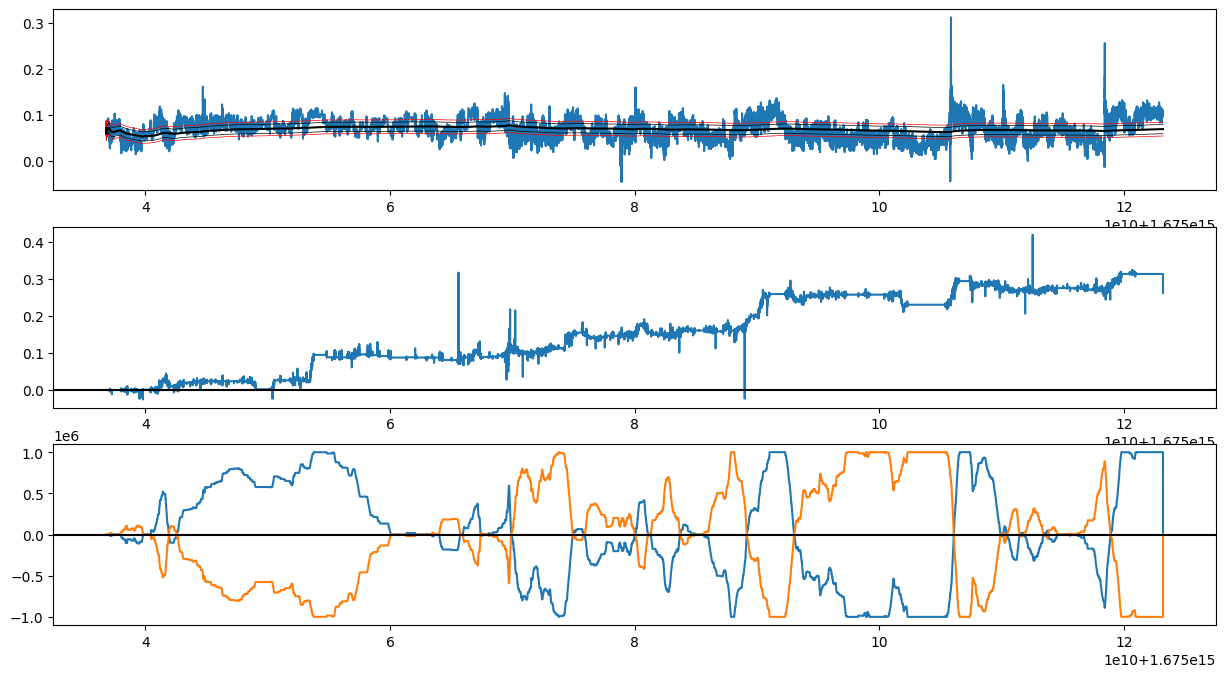

In [175]:
rs = pd.DataFrame(res)

plt.figure(figsize=(15,8))
plt.subplot(3, 1, 1)
plt.plot(rs['rms'], rs['spread'])
plt.plot(rs['rms'], rs['spread_ewm'], color='black')
plt.plot(rs['rms'], rs['spread_ewm']+0.01, color='black', linewidth=0.5)
plt.plot(rs['rms'], rs['spread_ewm']-0.01, color='black', linewidth=0.5)
plt.plot(rs['rms'], rs['spread_ewm']+(fee_B+fee_D)*1*100, color='red', linewidth=0.5)
plt.plot(rs['rms'], rs['spread_ewm']-(fee_B+fee_D)*1*100, color='red', linewidth=0.5)
plt.subplot(3, 1, 2)
plt.plot(rs['rms'], rs['pnl'])
plt.axhline(0, color='black')
#plt.ylim(-rs['pnl'].iloc[-1], rs['pnl'].iloc[-1]*1.5)
plt.subplot(3, 1, 3)
plt.plot(rs['rms'], rs['pos_size_B'])
plt.plot(rs['rms'], rs['pos_size_D'])
plt.axhline(0, color='black')
plt.show()

### 50ms, small fee

In [176]:
res = backtest(
    method='simple',
    open_th=2.0,
    close_th=0.5,
    amount_base=10,
    max_position_amount=1_000_000,
    ignore_first_items=1_000,
    count_items=None,
    latency_ms=50,
    fee_D=0.010/100,
    fee_B=0.005/100,
    ewm_span=1_500_000,
    ewm_dt0=50_000
)

Start calculating...
-----------------------------------------------------------------------------------------------------
#####################################################################################################
Elapsed: 376.39 s, per one = 2.35 us


In [177]:
print(f"PnL total = {res[-1]['pnl']:.6f}")

PnL total = 0.256615


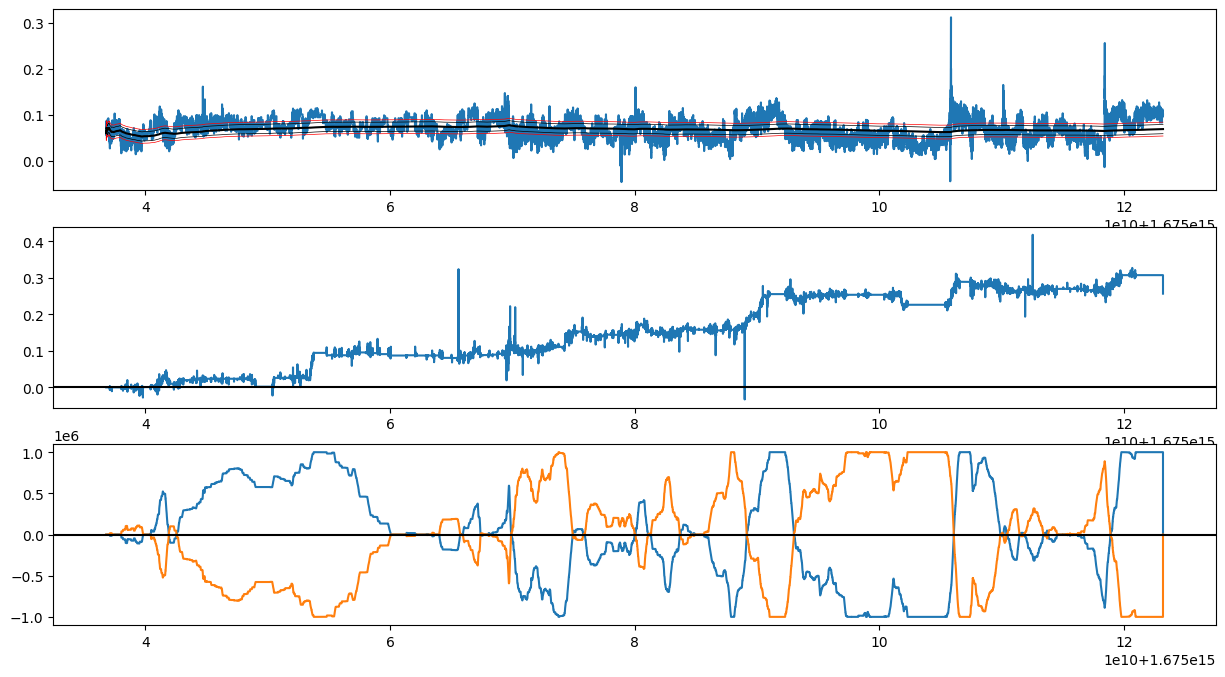

In [178]:
rs = pd.DataFrame(res)

plt.figure(figsize=(15,8))
plt.subplot(3, 1, 1)
plt.plot(rs['rms'], rs['spread'])
plt.plot(rs['rms'], rs['spread_ewm'], color='black')
plt.plot(rs['rms'], rs['spread_ewm']+0.01, color='black', linewidth=0.5)
plt.plot(rs['rms'], rs['spread_ewm']-0.01, color='black', linewidth=0.5)
plt.plot(rs['rms'], rs['spread_ewm']+(fee_B+fee_D)*1*100, color='red', linewidth=0.5)
plt.plot(rs['rms'], rs['spread_ewm']-(fee_B+fee_D)*1*100, color='red', linewidth=0.5)
plt.subplot(3, 1, 2)
plt.plot(rs['rms'], rs['pnl'])
plt.axhline(0, color='black')
#plt.ylim(-rs['pnl'].iloc[-1], rs['pnl'].iloc[-1]*1.5)
plt.subplot(3, 1, 3)
plt.plot(rs['rms'], rs['pos_size_B'])
plt.plot(rs['rms'], rs['pos_size_D'])
plt.axhline(0, color='black')
plt.show()

### 5ms, large fee

In [276]:
res = backtest(
    method='simple',
    open_th=2.0,
    close_th=0.5,
    amount_base=750, #700
    max_position_amount=1_000_000,
    ignore_first_items=1_000,
    count_items=None,
    latency_ms=5,
    fee_D=0.050/100,
    fee_B=0.0175/100,
    ewm_span=1_500_000,
    ewm_dt0=50_000
)

Start calculating...
-----------------------------------------------------------------------------------------------------
#####################################################################################################
Elapsed: 309.72 s, per one = 1.93 us


In [277]:
print(f"PnL total = {res[-1]['pnl']:.6f}")

PnL total = 0.039248


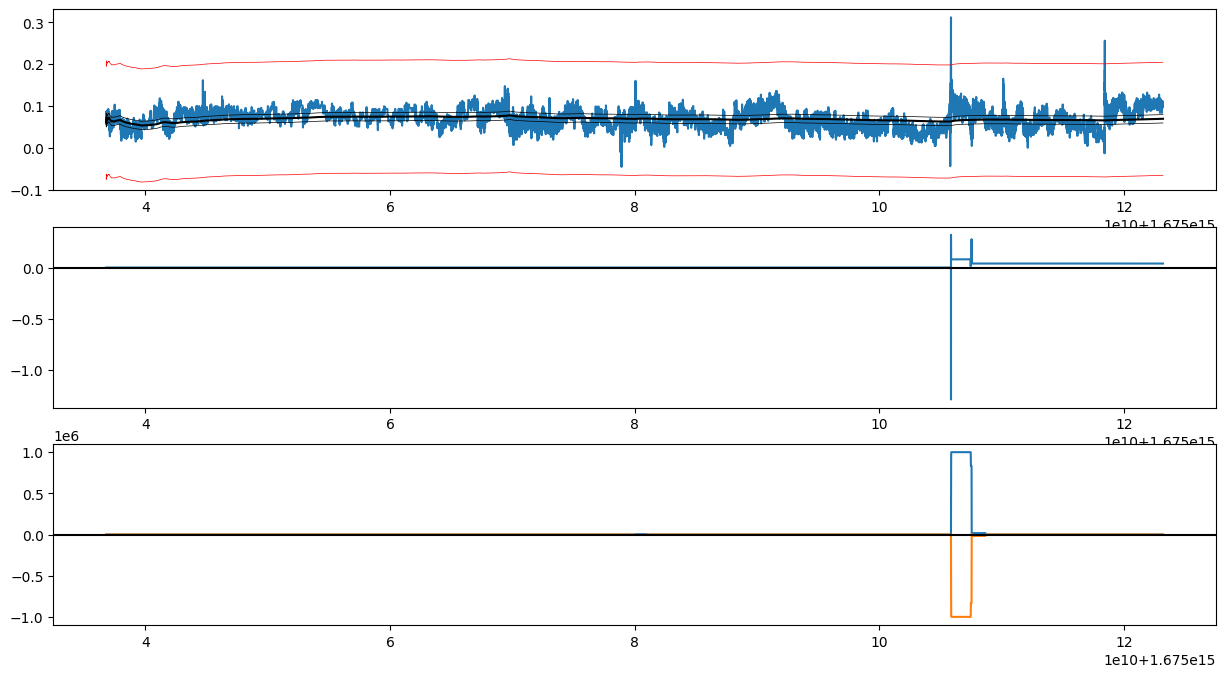

In [278]:
rs = pd.DataFrame(res)

plt.figure(figsize=(15,8))
plt.subplot(3, 1, 1)
plt.plot(rs['rms'], rs['spread'])
plt.plot(rs['rms'], rs['spread_ewm'], color='black')
plt.plot(rs['rms'], rs['spread_ewm']+0.01, color='black', linewidth=0.5)
plt.plot(rs['rms'], rs['spread_ewm']-0.01, color='black', linewidth=0.5)
plt.plot(rs['rms'], rs['spread_ewm']+(0.050/100 + 0.0175/100)*2*100, color='red', linewidth=0.5)
plt.plot(rs['rms'], rs['spread_ewm']-(0.050/100 + 0.0175/100)*2*100, color='red', linewidth=0.5)
plt.subplot(3, 1, 2)
plt.plot(rs['rms'], rs['pnl'])
plt.axhline(0, color='black')
#plt.ylim(-rs['pnl'].iloc[-1], rs['pnl'].iloc[-1]*1.5)
plt.subplot(3, 1, 3)
plt.plot(rs['rms'], rs['pos_size_B'])
plt.plot(rs['rms'], rs['pos_size_D'])
plt.axhline(0, color='black')
plt.show()

### 50ms, large fee

In [279]:
res = backtest(
    method='simple',
    open_th=2.0,
    close_th=0.5,
    amount_base=750, #700
    max_position_amount=1_000_000,
    ignore_first_items=1_000,
    count_items=None,
    latency_ms=50,
    fee_D=0.050/100,
    fee_B=0.0175/100,
    ewm_span=1_500_000,
    ewm_dt0=50_000
)

Start calculating...
-----------------------------------------------------------------------------------------------------
#####################################################################################################
Elapsed: 308.53 s, per one = 1.93 us


In [280]:
print(f"PnL total = {res[-1]['pnl']:.6f}")

PnL total = 0.037619


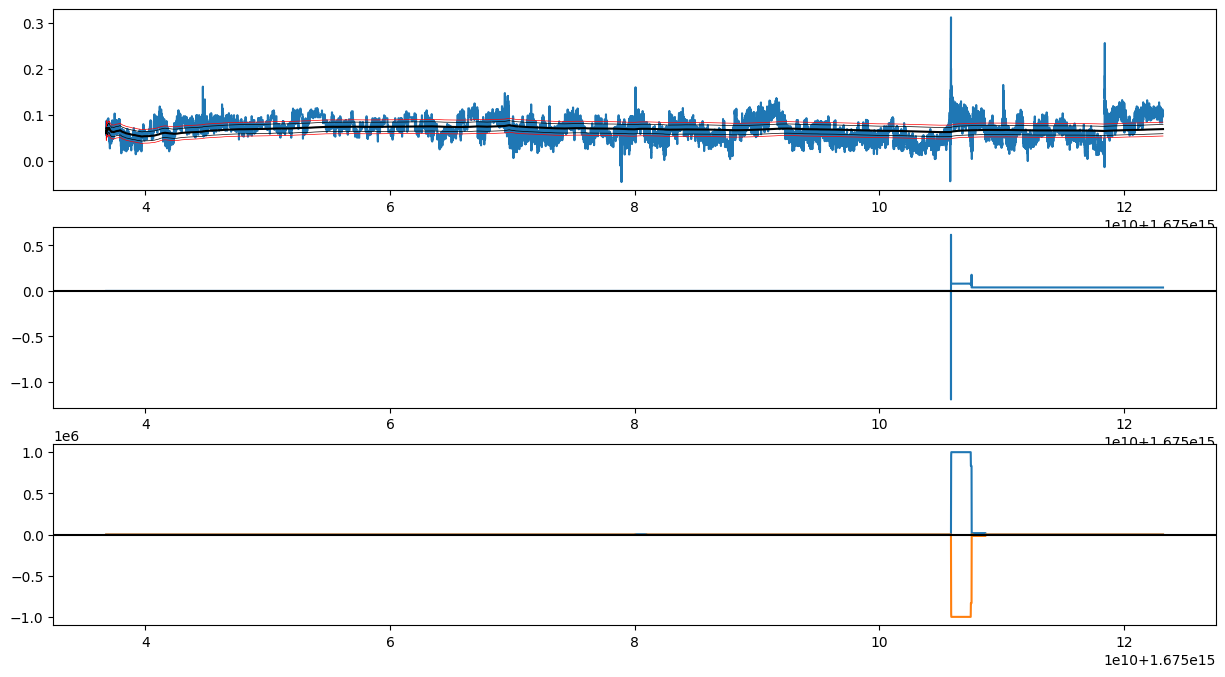

In [281]:
rs = pd.DataFrame(res)

plt.figure(figsize=(15,8))
plt.subplot(3, 1, 1)
plt.plot(rs['rms'], rs['spread'])
plt.plot(rs['rms'], rs['spread_ewm'], color='black')
plt.plot(rs['rms'], rs['spread_ewm']+0.01, color='black', linewidth=0.5)
plt.plot(rs['rms'], rs['spread_ewm']-0.01, color='black', linewidth=0.5)
plt.plot(rs['rms'], rs['spread_ewm']+(fee_B+fee_D)*1*100, color='red', linewidth=0.5)
plt.plot(rs['rms'], rs['spread_ewm']-(fee_B+fee_D)*1*100, color='red', linewidth=0.5)
plt.subplot(3, 1, 2)
plt.plot(rs['rms'], rs['pnl'])
plt.axhline(0, color='black')
#plt.ylim(-rs['pnl'].iloc[-1], rs['pnl'].iloc[-1]*1.5)
plt.subplot(3, 1, 3)
plt.plot(rs['rms'], rs['pos_size_B'])
plt.plot(rs['rms'], rs['pos_size_D'])
plt.axhline(0, color='black')
plt.show()

## linear regression

### 5ms, small fee

In [285]:
res = backtest(
    method='LR',
    open_th=2.0,
    open_lr_pnl_th=5.0,
    close_th=0.5,
    amount_base=10,
    max_position_amount=1_000_000,
    ignore_first_items=1_000,
    count_items=None,
    latency_ms=5,
    fee_D=0.010/100,
    fee_B=0.005/100,
    ewm_span=1_500_000,
    ewm_dt0=50_000
)

Start calculating...
-----------------------------------------------------------------------------------------------------
#####################################################################################################
Elapsed: 408.58 s, per one = 2.55 us


In [286]:
print(f"PnL total = {res[-1]['pnl']:.6f}")

PnL total = 0.183434


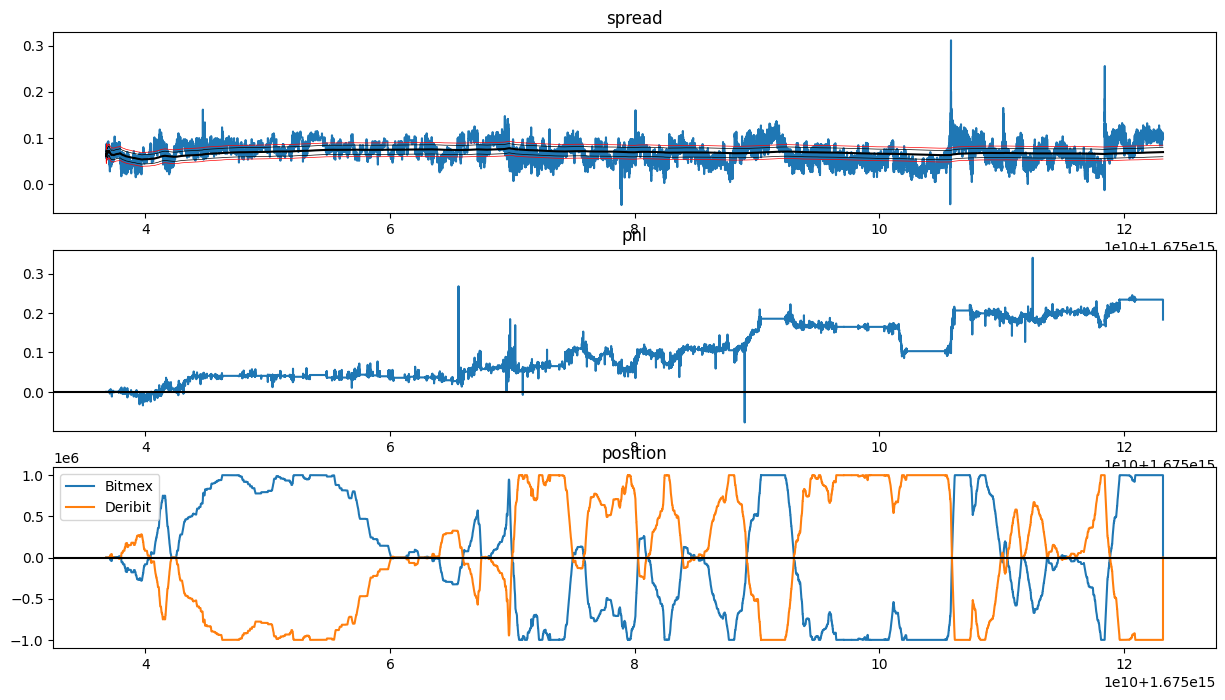

In [287]:
rs = pd.DataFrame(res)

plt.figure(figsize=(15,8))
plt.subplot(3, 1, 1)
plt.plot(rs['rms'], rs['spread'])
plt.plot(rs['rms'], rs['spread_ewm'], color='black')
plt.plot(rs['rms'], rs['spread_ewm']+0.01, color='black', linewidth=0.5)
plt.plot(rs['rms'], rs['spread_ewm']-0.01, color='black', linewidth=0.5)
plt.plot(rs['rms'], rs['spread_ewm']+(fee_B+fee_D)*1*100, color='red', linewidth=0.5)
plt.plot(rs['rms'], rs['spread_ewm']-(fee_B+fee_D)*1*100, color='red', linewidth=0.5)
plt.title('spread')
plt.subplot(3, 1, 2)
plt.plot(rs['rms'], rs['pnl'])
plt.axhline(0, color='black')
plt.title('pnl')
plt.subplot(3, 1, 3)
plt.plot(rs['rms'], rs['pos_size_B'], label='Bitmex')
plt.plot(rs['rms'], rs['pos_size_D'], label='Deribit')
plt.axhline(0, color='black')
plt.title('position')
plt.legend(loc="best")
plt.show()

### 50ms, large fee

In [288]:
res = backtest(
    method='LR',
    open_th=2.0,
    open_lr_pnl_th=5.0,
    close_th=0.5,
    amount_base=10,
    max_position_amount=1_000_000,
    ignore_first_items=1_000,
    count_items=None,
    latency_ms=50,
    fee_D=0.010/100,
    fee_B=0.005/100,
    ewm_span=1_500_000,
    ewm_dt0=50_000
)

Start calculating...
-----------------------------------------------------------------------------------------------------
#####################################################################################################
Elapsed: 436.06 s, per one = 2.72 us


In [289]:
print(f"PnL total = {res[-1]['pnl']:.6f}")

PnL total = 0.177533


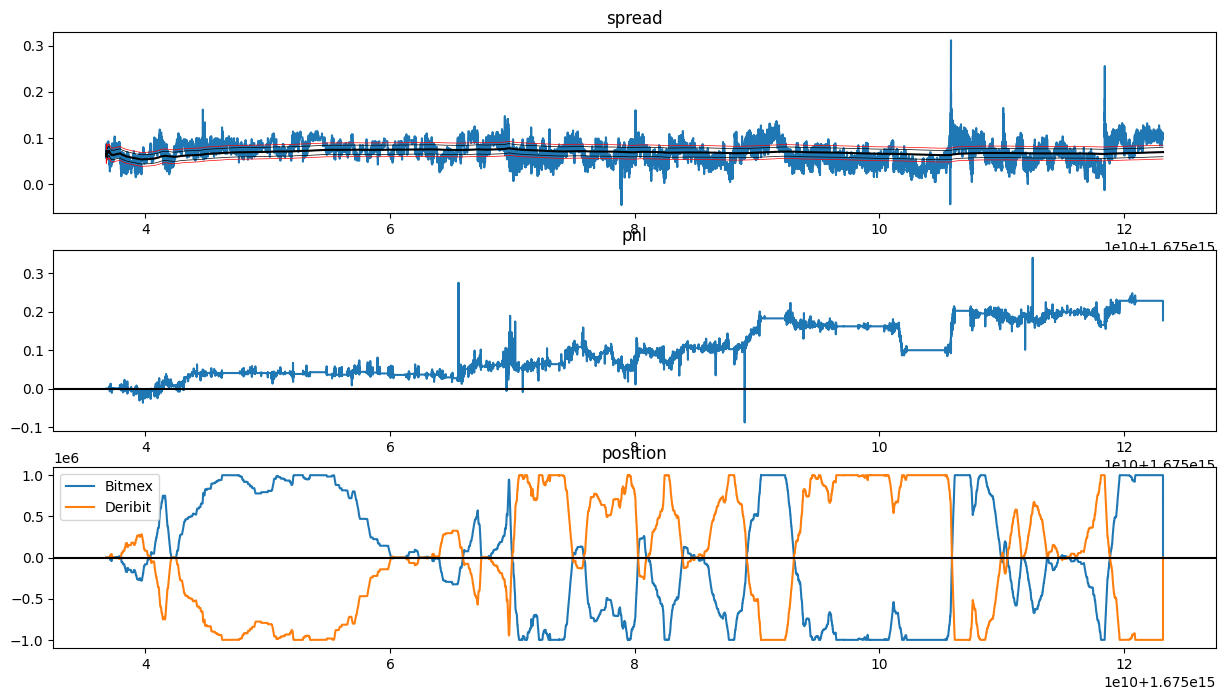

In [290]:
rs = pd.DataFrame(res)

plt.figure(figsize=(15,8))
plt.subplot(3, 1, 1)
plt.plot(rs['rms'], rs['spread'])
plt.plot(rs['rms'], rs['spread_ewm'], color='black')
plt.plot(rs['rms'], rs['spread_ewm']+0.01, color='black', linewidth=0.5)
plt.plot(rs['rms'], rs['spread_ewm']-0.01, color='black', linewidth=0.5)
plt.plot(rs['rms'], rs['spread_ewm']+(fee_B+fee_D)*1*100, color='red', linewidth=0.5)
plt.plot(rs['rms'], rs['spread_ewm']-(fee_B+fee_D)*1*100, color='red', linewidth=0.5)
plt.title('spread')
plt.subplot(3, 1, 2)
plt.plot(rs['rms'], rs['pnl'])
plt.axhline(0, color='black')
plt.title('pnl')
plt.subplot(3, 1, 3)
plt.plot(rs['rms'], rs['pos_size_B'], label='Bitmex')
plt.plot(rs['rms'], rs['pos_size_D'], label='Deribit')
plt.axhline(0, color='black')
plt.title('position')
plt.legend(loc="best")
plt.show()

### 5ms, large fee

In [310]:
res = backtest(
    method='LR',
    open_th=2.0,
    open_lr_pnl_th=30.0,
    close_th=0.5,
    amount_base=300,
    max_position_amount=1_000_000,
    ignore_first_items=1_000,
    count_items=None,
    latency_ms=5,
    fee_D=0.050/100,
    fee_B=0.0175/100,
    ewm_span=1_500_000,
    ewm_dt0=50_000
)

Start calculating...
-----------------------------------------------------------------------------------------------------
#####################################################################################################
Elapsed: 355.08 s, per one = 2.22 us


In [311]:
print(f"PnL total = {res[-1]['pnl']:.6f}")

PnL total = 0.047556


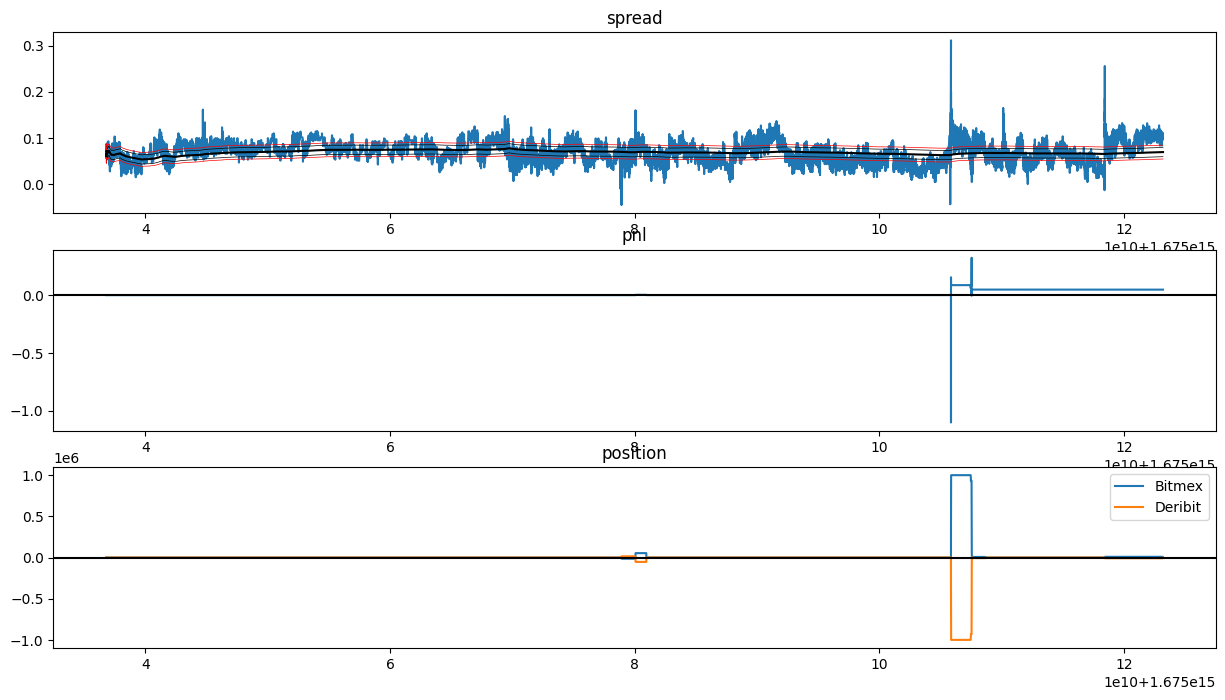

In [312]:
rs = pd.DataFrame(res)

plt.figure(figsize=(15,8))
plt.subplot(3, 1, 1)
plt.plot(rs['rms'], rs['spread'])
plt.plot(rs['rms'], rs['spread_ewm'], color='black')
plt.plot(rs['rms'], rs['spread_ewm']+0.01, color='black', linewidth=0.5)
plt.plot(rs['rms'], rs['spread_ewm']-0.01, color='black', linewidth=0.5)
plt.plot(rs['rms'], rs['spread_ewm']+(fee_B+fee_D)*1*100, color='red', linewidth=0.5)
plt.plot(rs['rms'], rs['spread_ewm']-(fee_B+fee_D)*1*100, color='red', linewidth=0.5)
plt.title('spread')
plt.subplot(3, 1, 2)
plt.plot(rs['rms'], rs['pnl'])
plt.axhline(0, color='black')
plt.title('pnl')
plt.subplot(3, 1, 3)
plt.plot(rs['rms'], rs['pos_size_B'], label='Bitmex')
plt.plot(rs['rms'], rs['pos_size_D'], label='Deribit')
plt.axhline(0, color='black')
plt.title('position')
plt.legend(loc="best")
plt.show()

### 50ms, large fee

In [313]:
res = backtest(
    method='LR',
    open_th=2.0,
    open_lr_pnl_th=30.0,
    close_th=0.5,
    amount_base=300,
    max_position_amount=1_000_000,
    ignore_first_items=1_000,
    count_items=None,
    latency_ms=50,
    fee_D=0.050/100,
    fee_B=0.0175/100,
    ewm_span=1_500_000,
    ewm_dt0=50_000
)

Start calculating...
-----------------------------------------------------------------------------------------------------
#####################################################################################################
Elapsed: 353.82 s, per one = 2.21 us


In [314]:
print(f"PnL total = {res[-1]['pnl']:.6f}")

PnL total = 0.045037


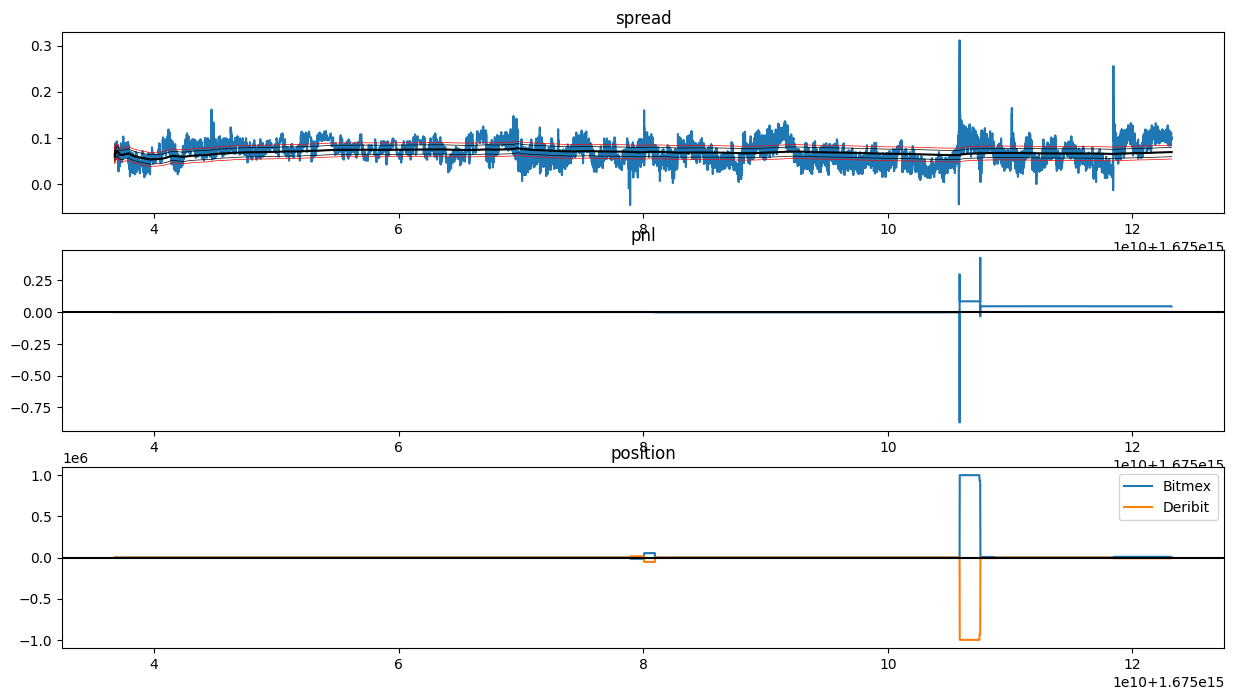

In [315]:
rs = pd.DataFrame(res)

plt.figure(figsize=(15,8))
plt.subplot(3, 1, 1)
plt.plot(rs['rms'], rs['spread'])
plt.plot(rs['rms'], rs['spread_ewm'], color='black')
plt.plot(rs['rms'], rs['spread_ewm']+0.01, color='black', linewidth=0.5)
plt.plot(rs['rms'], rs['spread_ewm']-0.01, color='black', linewidth=0.5)
plt.plot(rs['rms'], rs['spread_ewm']+(fee_B+fee_D)*1*100, color='red', linewidth=0.5)
plt.plot(rs['rms'], rs['spread_ewm']-(fee_B+fee_D)*1*100, color='red', linewidth=0.5)
plt.title('spread')
plt.subplot(3, 1, 2)
plt.plot(rs['rms'], rs['pnl'])
plt.axhline(0, color='black')
plt.title('pnl')
plt.subplot(3, 1, 3)
plt.plot(rs['rms'], rs['pos_size_B'], label='Bitmex')
plt.plot(rs['rms'], rs['pos_size_D'], label='Deribit')
plt.axhline(0, color='black')
plt.title('position')
plt.legend(loc="best")
plt.show()

# conclusion

Here are the results:

---

For **simple deviation** from the average spread:

5ms, low fee: 0.261990

50ms, low fee: 0.256615

5ms, high fee: 0.039248

50ms, high fee: 0.037619

---

For **linear regression** strategy:

5ms, low fee: 0.183434

50ms, low fee: 0.177533

5ms, high fee: 0.047556

50ms, high fee: 0.045037

Opportunities for improvement:

1) Did not use variable order sizes. The larger the deviation, the larger the order size could be.

2) Did not check the current volume in the order book to see how much can actually be filled at that price.

3) Could use FOK/IOC order types to grab volume at the exact price without leaving leftovers.

4) Study volume/density imbalance behavior separately at extreme spread points (very high or very low) and improve entry filtering.

5) Optimize entry and exit thresholds (via GridSearch or similar techniques).

6) Track the average entry spread and try to improve it while holding the position - exit only under favorable conditions or via stop-loss.

7) Implement predictive models for spread movement over 5–50ms, or short-term price direction models.

However, all of this requires much deeper work and several weeks or months of additional data to reduce overfitting and improve generalization.